In [52]:
# Import the Necessary Dependencies

# Data Manipulation
import re ## regular expression operator
import numpy as np
import pandas as pd
import string 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Methods and stopwords text processing
import nltk ## natural language toolkit
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer


# Machine Learning Libraries
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


In [53]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('twitter_data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

#Exploratory Data Analysis
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [54]:
print('length of data is', len(df))


length of data is 1600000


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [56]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [57]:
#Checking for null values
np.sum(df.isnull().any(axis=1))

0

In [58]:
#Rows and columns in the dataset
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [59]:
#Check unique target values
df['target'].unique()

array([0, 4], dtype=int64)

In [60]:
#Check the number of target values
df['target'].nunique()

2

In [61]:
#Data Visualization of Target Variables

# # Plotting the distribution for dataset.
# ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
# ax.set_xticklabels(['Negative','Positive'], rotation=0)
# # Storing data in lists.
# text, sentiment = list(df['text']), list(df['target'])

In [62]:
# import seaborn as sns
# sns.countplot(x='target', data=df)

In [63]:
#Data Preprocessing

# data=df[['text','target']]
# data['target'] = data['target'].replace(4,1)
# data['target'].unique()


In [64]:
df['text'].tail()

1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, dtype: object

In [65]:
# Convert all text to lowercase
df['text'] = df['text'].str.lower()
df['text'].tail()

1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

In [66]:
#Cleaning and removing punctuations

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].tail()

1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy 38th birthday to my boo of alll time tup...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [67]:
#Cleaning and removing repeating characters

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail()

1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy 38th birthday to my boo of alll time tup...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [68]:
#Cleaning and removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].tail()

1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy 38th birthday to my boo of alll time tup...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [69]:
#Cleaning and removing numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].tail()

1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy th birthday to my boo of alll time tupac...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [70]:
# Removing # and @ characters from tweets

def cleaning_characters(data):
    return re.sub(r'\@\w+|\#','', data)
df['text'] = df['text'].apply(lambda x: cleaning_characters(x))
df['text'].tail()


1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy th birthday to my boo of alll time tupac...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [71]:
#Defining set containing all stopwords in English.

nltk.download ('stopwords')
stop_words = set(stopwords.words( 'english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thamires\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
#Cleaning and removing the above stop words list from the tweet text

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].tail()


1599995                        woke school best feeling ever
1599996    thewdbcom cool hear old walt interviews â« ht...
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [74]:
# Doing tokenization of Tweet Text

tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].tail()

1599995                  [woke, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: text, dtype: object

In [77]:
# Stemming process

st = nltk.PorterStemmer()
def stemming_process(data):
    text = [st.stem(word) for word in data]
    return data
df['text']= df['text'].apply(lambda x: stemming_process(x))
df['text'].tail()



1599995                  [woke, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: text, dtype: object

In [78]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
df['text'].tail()

1599995                  [woke, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: text, dtype: object

In [84]:
# count = 0
# for index, row in df.iterrows():
#     if row['target'] != count:
#         print(index-1)
#         count +=2

# where start and where ends negative and positive


799999
800000


In [96]:
# Changing the target values for easy understanding

df=df[['text','target']]
df['target'] = df['target'].replace(4,1)
df['target'].unique()


C:\Users\Thamires\AppData\Local\Temp\ipykernel_16804\1710829185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].replace(4,1)


array([0, 1], dtype=int64)

In [97]:
# Separating positive and negative tweets

data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]
df = pd.concat([data_pos, data_neg])


C:\Users\Thamires\AppData\Local\Temp\ipykernel_16804\4043311928.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data_neg = df['text'][:800000]


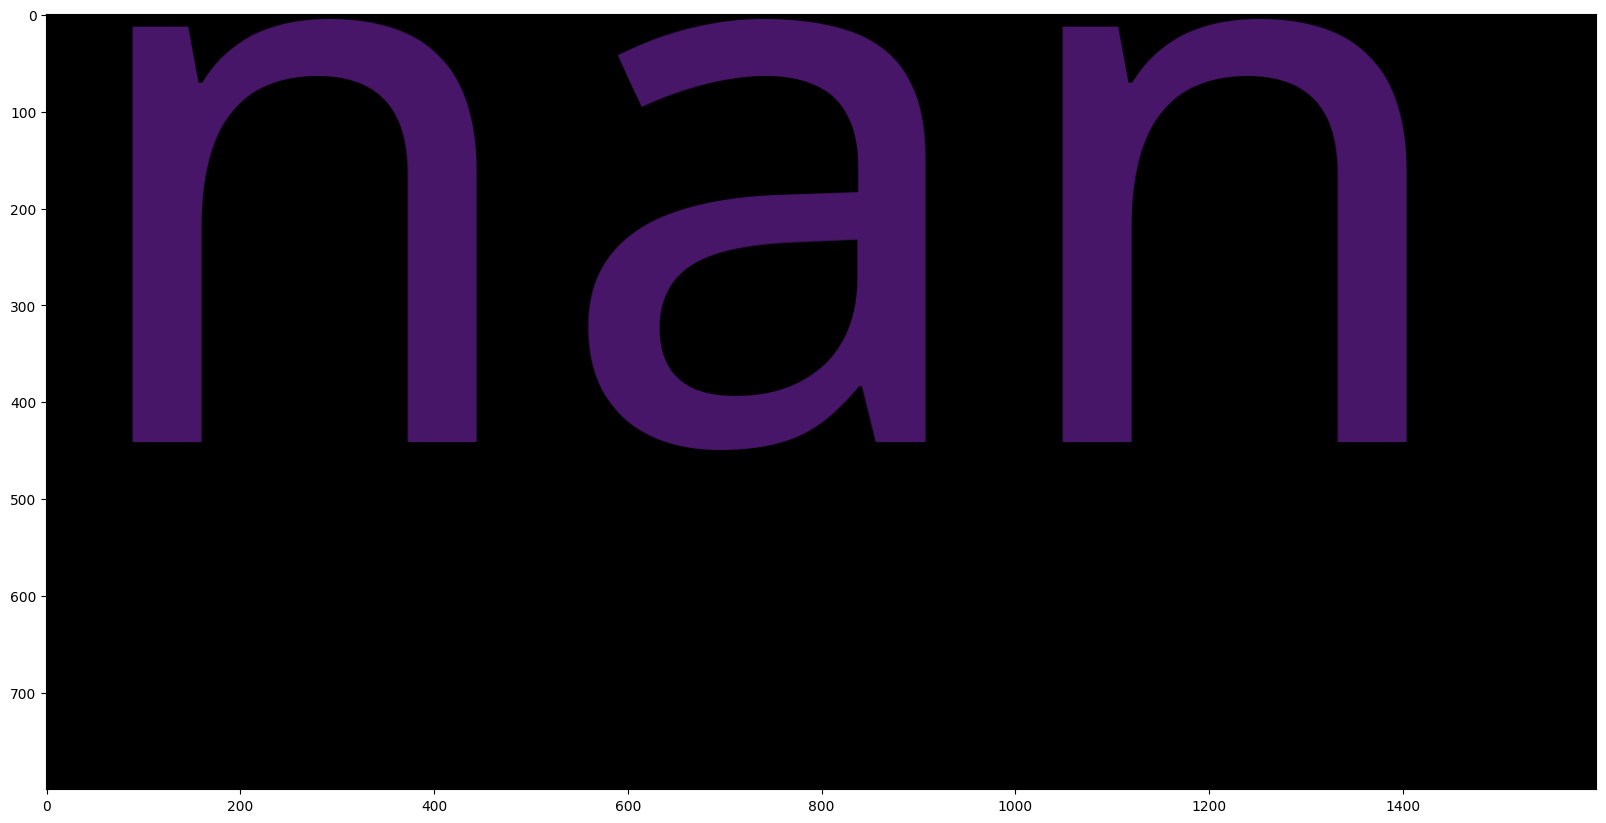

In [102]:
# Plot words of negative tweets

data_neg = df['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_neg)))
plt.imshow(wc)

In [ ]:
# Plot tweets of positive tweets

data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [85]:
# # #Separating positive and negative tweets

# data_pos = df[df['target'] == 1]
# data_neg = df[df['target'] == 0]

# data_pos = data_pos.iloc[:int(20000)]
# data_neg = data_neg.iloc[:int(20000)]

# dataset = pd.concat([data_pos, data_neg])

# df['text']=df['text'].str.lower()
# df['text'].tail()

1599995   NaN
1599996   NaN
1599997   NaN
1599998   NaN
1599999   NaN
Name: text, dtype: float64